<h4 style="color:#1f77b4; font-weight:bold;">
Retention Curve (Linear Interpolation)
</h4>


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


<h4 style="color:#1f77b4; font-weight:bold;">
Retention Curve (Linear Interpolation)
</h4>

In [27]:
def build_retention_curve(days, d1, d3, d7, d14):
    known_days = np.array([0, 1, 3, 7, 14], dtype=float)
    known_retention = np.array([1.0, d1, d3, d7, d14], dtype=float)

    all_days = np.arange(0, days + 1, dtype=float)

    # Linear interpolation between known retention points
    retention = np.interp(all_days, known_days, known_retention)

    # Linear extrapolation after Day 14 using the last observed slope
    slope = (d14 - d7) / (14 - 7)
    for day in range(15, days + 1):
        retention[day] = retention[day - 1] + slope

    # Retention must stay within logical bounds
    retention = np.clip(retention, 0, 1)
    return retention

Creates a daily retention curve from sparse retention checkpoints (D1, D3, D7, D14) so DAU can be simulated day by day.

<h4 style="color:#1f77b4; font-weight:bold;">
DAU Simulation (Cohort-Based)
</h4>


In [28]:
def simulate_dau(days, daily_installs, retention):
    installs = np.full(days + 1, daily_installs, dtype=float)
    dau = np.zeros(days + 1, dtype=float)

    for day in range(0, days + 1):
        active_users = 0.0
        for install_day in range(0, day + 1):
            age = day - install_day
            active_users += installs[install_day] * retention[age]
        dau[day] = active_users

    return dau


Simulates Daily Active Users by summing all surviving cohorts based on their age-specific retention.

<h4 style="color:#1f77b4; font-weight:bold;">
Revenue Calculation (IAP + Ads)
</h4>


In [29]:
def compute_revenue(dau, purchase_ratio, arppu, ecpm, impressions_per_dau):
    buyers = dau * purchase_ratio
    iap_revenue = buyers * arppu

    impressions = dau * impressions_per_dau
    ad_revenue = (impressions / 1000.0) * ecpm

    total_revenue = iap_revenue + ad_revenue

    return pd.DataFrame({
        "dau": dau,
        "buyers": buyers,
        "iap_revenue": iap_revenue,
        "impressions": impressions,
        "ad_revenue": ad_revenue,
        "total_revenue": total_revenue
    })


Converts DAU into daily monetization by modeling in-app purchases and advertising revenue streams.

<h4 style="color:#1f77b4; font-weight:bold;">
Variant Definitions & Base Runner
</h4>


In [30]:
DAYS_15 = 15
DAYS_30 = 30
DAILY_INSTALLS = 20000
ARPPU = 1.0  # constant scaling assumption

variant_A = {
    "purchase_ratio": 0.0305,
    "ecpm": 9.80,
    "impressions_per_dau": 2.3,
    "d1": 0.53, "d3": 0.27, "d7": 0.17, "d14": 0.06
}

variant_B = {
    "purchase_ratio": 0.0315,
    "ecpm": 10.80,
    "impressions_per_dau": 1.6,
    "d1": 0.48, "d3": 0.25, "d7": 0.19, "d14": 0.09
}

def run_variant(days, params, daily_installs=DAILY_INSTALLS):
    retention = build_retention_curve(days, params["d1"], params["d3"], params["d7"], params["d14"])
    dau = simulate_dau(days, daily_installs, retention)

    df = compute_revenue(
        dau=dau,
        purchase_ratio=params["purchase_ratio"],
        arppu=ARPPU,
        ecpm=params["ecpm"],
        impressions_per_dau=params["impressions_per_dau"]
    )

    df["day"] = np.arange(0, days + 1)
    return df


Defines experiment parameters and provides a reusable execution function for all base A/B scenarios.

<h4 style="color:#2ca02c; font-weight:bold;">
a) Which variant will have the most daily active users after 15 days?
</h4>


In [31]:
dfA15 = run_variant(DAYS_15, variant_A)
dfB15 = run_variant(DAYS_15, variant_B)

dau_A_15 = dfA15.loc[dfA15["day"] == 15, "dau"].iloc[0]
dau_B_15 = dfB15.loc[dfB15["day"] == 15, "dau"].iloc[0]

print("Day 15 DAU - Variant A:", dau_A_15)
print("Day 15 DAU - Variant B:", dau_B_15)


Day 15 DAU - Variant A: 76485.71428571429
Day 15 DAU - Variant B: 79014.28571428571


Answers Task 1(a) by identifying which variant has more daily active users after 15 days.

<h4 style="color:#2ca02c; font-weight:bold;">
b) Which variant will earn the most total money by Day 15?
</h4>


In [32]:
revenue_A_15 = dfA15["total_revenue"].sum()
revenue_B_15 = dfB15["total_revenue"].sum()

print("Total Revenue by Day 15 - Variant A:", revenue_A_15)
print("Total Revenue by Day 15 - Variant B:", revenue_B_15)


Total Revenue by Day 15 - Variant A: 48939.25028571428
Total Revenue by Day 15 - Variant B: 44570.98285714286


Answers Task 1(b) by comparing cumulative monetization performance over the first 15 days.

<h4 style="color:#2ca02c; font-weight:bold;">
c) If we look at the total money earned by Day 30 instead, does our choice change?
</h4>


In [33]:
dfA30 = run_variant(DAYS_30, variant_A)
dfB30 = run_variant(DAYS_30, variant_B)

revenue_A_30 = dfA30["total_revenue"].sum()
revenue_B_30 = dfB30["total_revenue"].sum()

print("Total Revenue by Day 30 - Variant A:", revenue_A_30)
print("Total Revenue by Day 30 - Variant B:", revenue_B_30)


Total Revenue by Day 30 - Variant A: 110436.85714285716
Total Revenue by Day 30 - Variant B: 104608.70999999998


Answers Task 1(c) by evaluating whether long-term monetization changes the preferred variant.

<h4 style="color:#2ca02c; font-weight:bold;">
Base Scenario Visualizations (DAU & Revenue)
</h4>


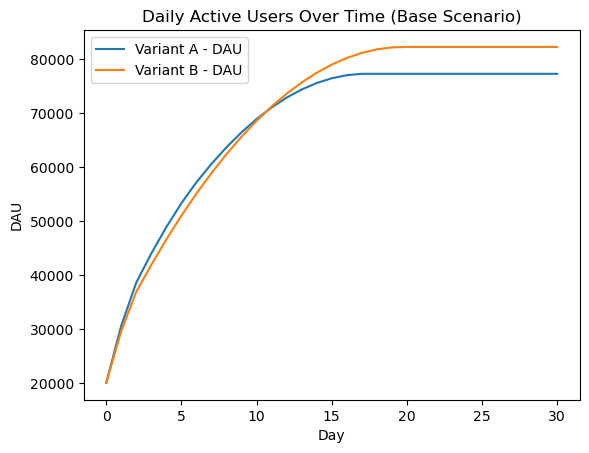

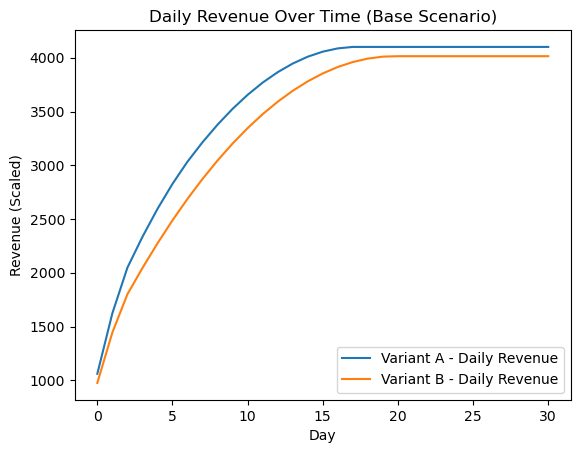

In [36]:
# DAU over time (0–30)
plt.figure()
plt.plot(dfA30["day"], dfA30["dau"], label="Variant A - DAU")
plt.plot(dfB30["day"], dfB30["dau"], label="Variant B - DAU")
plt.title("Daily Active Users Over Time (Base Scenario)")
plt.xlabel("Day")
plt.ylabel("DAU")
plt.legend()
plt.show()

# Daily revenue over time (0–30)
plt.figure()
plt.plot(dfA30["day"], dfA30["total_revenue"], label="Variant A - Daily Revenue")
plt.plot(dfB30["day"], dfB30["total_revenue"], label="Variant B - Daily Revenue")
plt.title("Daily Revenue Over Time (Base Scenario)")
plt.xlabel("Day")
plt.ylabel("Revenue (Scaled)")
plt.legend()
plt.show()


Visualizes DAU and daily revenue trends over a 30-day period for the base A/B test scenario, allowing comparison of growth and monetization dynamics between Variant A and Variant B.

<h4 style="color:#2ca02c; font-weight:bold;">
d) What if we run a 10-day sale starting on Day 15 (boosting everyone's purchase rate by 1%)? 
    Does this change which variant earns more total money by Day 30?
</h4>


In [34]:
def build_purchase_rate_curve(days, base_rate, sale_start, sale_length, boost):
    rates = np.full(days + 1, base_rate)
    sale_end = sale_start + sale_length - 1

    for day in range(sale_start, sale_end + 1):
        rates[day] = base_rate + boost

    return rates


def compute_revenue_with_sale(dau, purchase_rates, arppu, ecpm, impressions_per_dau):
    buyers = dau * purchase_rates
    iap_revenue = buyers * arppu

    impressions = dau * impressions_per_dau
    ad_revenue = (impressions / 1000.0) * ecpm

    total_revenue = iap_revenue + ad_revenue

    return pd.DataFrame({
        "dau": dau,
        "purchase_rate": purchase_rates,
        "total_revenue": total_revenue
    })


def run_variant_with_sale(days, params, sale_start, sale_length, boost):
    retention = build_retention_curve(days, params["d1"], params["d3"], params["d7"], params["d14"])
    dau = simulate_dau(days, DAILY_INSTALLS, retention)

    purchase_rates = build_purchase_rate_curve(
        days, params["purchase_ratio"], sale_start, sale_length, boost
    )

    df = compute_revenue_with_sale(
        dau, purchase_rates, ARPPU, params["ecpm"], params["impressions_per_dau"]
    )

    df["day"] = np.arange(0, days + 1)
    return df


dfA30_sale = run_variant_with_sale(30, variant_A, sale_start=15, sale_length=10, boost=0.01)
dfB30_sale = run_variant_with_sale(30, variant_B, sale_start=15, sale_length=10, boost=0.01)

print("Revenue with Sale - A:", dfA30_sale["total_revenue"].sum())
print("Revenue with Sale - B:", dfB30_sale["total_revenue"].sum())


Revenue with Sale - A: 118157.4285714286
Revenue with Sale - B: 112768.70999999998


Answers Task 1(d) by simulating a temporary monetization boost and evaluating its impact on 30-day revenue.

<h4 style="color:#2ca02c; font-weight:bold;">
e) On Day 20 we add a new user source. From then on, we get 12,000 users from the original source and 8,000 from this new one. The new users' retention is described by these formulas. With this mix of old and new users, which variant makes more total money by Day 30?
</h4>


<h4 style="color:#2ca02c; font-weight:bold;">
- Variant A (New): $Retention = 0.58 \cdot e^{-0.12(x-1)}$
- Variant B (New): $Retention = 0.52 \cdot e^{-0.10(x-1)}$
</h4>


In [35]:
def new_source_retention_curve(days, base, decay):
    retention = np.zeros(days + 1)
    retention[0] = 1.0

    for day in range(1, days + 1):
        retention[day] = base * np.exp(-decay * (day - 1))

    return np.clip(retention, 0, 1)


def simulate_dau_mixed_sources(days, old_installs, new_installs, old_ret, new_ret, new_start):
    dau = np.zeros(days + 1)

    for day in range(0, days + 1):
        active = 0.0
        for install_day in range(0, day + 1):
            age = day - install_day
            active += old_installs * old_ret[age]

            if install_day >= new_start:
                active += new_installs * new_ret[age]

        dau[day] = active

    return dau


old_ret_A = build_retention_curve(30, **{k: variant_A[k] for k in ["d1","d3","d7","d14"]})
old_ret_B = build_retention_curve(30, **{k: variant_B[k] for k in ["d1","d3","d7","d14"]})

new_ret_A = new_source_retention_curve(30, base=0.58, decay=0.12)
new_ret_B = new_source_retention_curve(30, base=0.52, decay=0.10)

dauA_mix = simulate_dau_mixed_sources(30, 12000, 8000, old_ret_A, new_ret_A, 20)
dauB_mix = simulate_dau_mixed_sources(30, 12000, 8000, old_ret_B, new_ret_B, 20)

dfA_mix = compute_revenue(dauA_mix, variant_A["purchase_ratio"], ARPPU, variant_A["ecpm"], variant_A["impressions_per_dau"])
dfB_mix = compute_revenue(dauB_mix, variant_B["purchase_ratio"], ARPPU, variant_B["ecpm"], variant_B["impressions_per_dau"])

print("Revenue with New Source - A:", dfA_mix["total_revenue"].sum())
print("Revenue with New Source - B:", dfB_mix["total_revenue"].sum())


Revenue with New Source - A: 80764.83150749755
Revenue with New Source - B: 75565.267853566


Answers Task 1(e) by modeling a mixed acquisition strategy with source-specific retention behaviors.

<h4 style="color:#2ca02c; font-weight:bold;">
f) Which one should you prioritize, and why? If you could only make one of these improvements:

<h5 style="color:#2ca02c; font-weight:bold;">
 (1) Run the temporary 10-day sale (from d) 
</h5>


<h5 style="color:#2ca02c; font-weight:bold;">
 (2) Add the new, permanent user source (from e/f)
</h5>




If only one improvement could be prioritized, I would choose adding the new, permanent user source.
The temporary 10-day sale provides a short-term increase in purchase rate, but its impact is limited to the campaign period and does not improve long-term user engagement or retention. Once the sale ends, monetization quickly returns to baseline levels.
In contrast, the new user source introduces a sustained increase in daily active users. Although the new users have different retention characteristics, their continuous inflow compounds over time and positively affects both advertising and in-app purchase revenue. This creates a more stable and scalable growth dynamic.
From a long-term product and business perspective, prioritizing the permanent user source is more impactful than a temporary monetization boost.
